In [1]:
# Instalación necesaria (solo en Colab o entornos donde no esté instalado)
!pip install -q imbalanced-learn xgboost shap tabulate

# Importación optimizada y sin duplicados
import pandas as pd
import numpy as np
from collections import Counter
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier, plot_importance

import shap


In [2]:
# URL directa al CSV
url = 'https://raw.githubusercontent.com/DonJulianCode/Challenge-ONE-Data-Science-Telecom-X-parte-2/main/df_plano.csv'

# Cargar como DataFrame
df = pd.read_csv(url)

# Mostrar las primeras filas
df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0.0,Yes,Yes,9.0,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0.0,No,No,9.0,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0.0,No,No,4.0,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1.0,Yes,No,13.0,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1.0,Yes,No,3.0,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40,2.796667


In [3]:
# Ver estructura general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer.gender            7043 non-null   object 
 3   customer.SeniorCitizen     7043 non-null   float64
 4   customer.Partner           7043 non-null   object 
 5   customer.Dependents        7043 non-null   object 
 6   customer.tenure            7043 non-null   float64
 7   phone.PhoneService         7043 non-null   object 
 8   phone.MultipleLines        7043 non-null   object 
 9   internet.InternetService   7043 non-null   object 
 10  internet.OnlineSecurity    7043 non-null   object 
 11  internet.OnlineBackup      7043 non-null   object 
 12  internet.DeviceProtection  7043 non-null   object 
 13  internet.TechSupport       7043 non-null   objec

In [4]:
# Verificar valores nulos por columna
df.isnull().sum()


,0
customerID,0
Churn,0
customer.gender,0
customer.SeniorCitizen,0
customer.Partner,0
customer.Dependents,0
customer.tenure,0
phone.PhoneService,0
phone.MultipleLines,0
internet.InternetService,0


In [5]:
# Estadísticas descriptivas para variables numéricas
df.describe()

,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias
count,7043.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441,2.158723
std,0.368612,24.559481,30.090047,2266.771362,1.003002
min,0.000000,0.000000,18.250000,18.800000,0.608333
25%,0.000000,9.000000,35.500000,401.450000,1.183333
50%,0.000000,29.000000,70.350000,1397.475000,2.345000
75%,0.000000,55.000000,89.850000,3794.737500,2.995000
max,1.000000,72.000000,118.750000,8684.800000,3.958333


In [6]:
# Ahora reviso la cantidad de valores nulos en 'account.Charges.Total'
df['account.Charges.Total'].isnull().sum()


np.int64(11)

In [7]:
# Como solo hay 11 casos nulos, ahora elimino esas filas para evitar problemas en el modelado
df = df.dropna(subset=['account.Charges.Total']).reset_index(drop=True)

# Confirmo que ya no existen valores nulos
df['account.Charges.Total'].isnull().sum()


np.int64(0)

## Eliminación de Columnas Irrelevantes

### Elimina columnas que no aportan valor al análisis o a los modelos predictivos, como identificadores únicos (por ejemplo, el ID del cliente). Estas columnas no ayudan en la predicción de la cancelación y pueden incluso perjudicar el desempeño de los modelos

In [8]:
# Ahora elimino columnas que no aportan valor al análisis ni a los modelos predictivos

# 'customerID' es un identificador único y no entrega información útil para predecir Churn
df = df.drop(columns=['customerID'])

# ✅ Confirmo que fue eliminada
df.columns


Index(['Churn', 'customer.gender', 'customer.SeniorCitizen',
       'customer.Partner', 'customer.Dependents', 'customer.tenure',
       'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService',
       'internet.OnlineSecurity', 'internet.OnlineBackup',
       'internet.DeviceProtection', 'internet.TechSupport',
       'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract',
       'account.PaperlessBilling', 'account.PaymentMethod',
       'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias'],
      dtype='object')

## Encoding

### Transforma las variables categóricas a formato numérico para hacerlas compatibles con los algoritmos de machine learning. Utiliza un método de codificación adecuado, como one-hot encoding.

In [9]:
# Ahora reviso qué columnas son categóricas (tipo object)
cat_cols = df.select_dtypes(include='object').columns.tolist()

# Excluyo la variable objetivo 'Churn' para codificarla aparte
cat_cols = [col for col in cat_cols if col != 'Churn']

# Realizo One-Hot Encoding sobre las variables categóricas, eliminando la primera categoría para evitar multicolinealidad
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Codifico la variable objetivo: 'Yes' → 1, 'No' → 0
df_encoded['Churn'] = df_encoded['Churn'].map({'Yes': 1, 'No': 0})

# Reviso cómo quedó la estructura final
df_encoded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Churn                                          7032 non-null   int64  
 1   customer.SeniorCitizen                         7032 non-null   float64
 2   customer.tenure                                7032 non-null   float64
 3   account.Charges.Monthly                        7032 non-null   float64
 4   account.Charges.Total                          7032 non-null   float64
 5   Cuentas_Diarias                                7032 non-null   float64
 6   customer.gender_Male                           7032 non-null   bool   
 7   customer.Partner_Yes                           7032 non-null   bool   
 8   customer.Dependents_Yes                        7032 non-null   bool   
 9   phone.PhoneService_Yes                         7032 

# Verificación de la Proporción de Cancelación (Churn)

### Calcula la proporción de clientes que cancelaron en relación con los que permanecieron activos. Evalúa si existe un desbalance entre las clases, ya que esto puede impactar en los modelos predictivos y en el análisis de los resultados.

In [10]:
# Verifico la proporción de cancelación (Churn)

# Cantidad y proporción
churn_counts = df_encoded['Churn'].value_counts().sort_index()
churn_ratio = df_encoded['Churn'].value_counts(normalize=True).sort_index()

# Creo tabla combinada
churn_summary = [
    ["Activo (0)", churn_counts[0], f"{churn_ratio[0]:.2%}"],
    ["Canceló (1)", churn_counts[1], f"{churn_ratio[1]:.2%}"]
]

#  Muestro tabla con tabulate
print("Distribución de clientes según Churn:\n")
print(tabulate(churn_summary, headers=["Clase", "Cantidad", "Proporción"], tablefmt="fancy_grid"))

Distribución de clientes según Churn:

╒═════════════╤════════════╤══════════════╕
│ Clase       │   Cantidad │ Proporción   │
╞═════════════╪════════════╪══════════════╡
│ Activo (0)  │       5163 │ 73.42%       │
├─────────────┼────────────┼──────────────┤
│ Canceló (1) │       1869 │ 26.58%       │
╘═════════════╧════════════╧══════════════╛


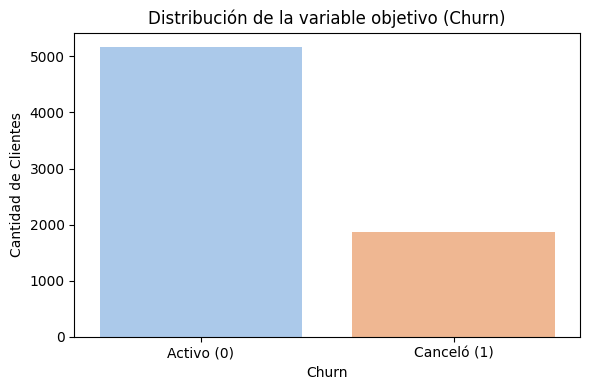

In [11]:
# Visualización corregida
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df_encoded, hue='Churn', legend=False, palette='pastel')
plt.title("Distribución de la variable objetivo (Churn)")
plt.xticks(ticks=[0,1], labels=["Activo (0)", "Canceló (1)"])
plt.xlabel("Churn")
plt.ylabel("Cantidad de Clientes")
plt.tight_layout()
plt.show()


# Balanceo de Clases

### Si deseas profundizar en el análisis, aplica técnicas de balanceo como undersampling o oversampling. En situaciones de fuerte desbalanceo, herramientas como SMOTE pueden ser útiles para generar ejemplos sintéticos de la clase minoritaria.

In [12]:
# Primero separo X e y
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# Luego divido en train y test (estratificado)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Ahora aplico SMOTE SOLO al set de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Verifico que ahora las clases estén balanceadas
print("Distribución después de aplicar SMOTE:")
print(Counter(y_train_bal))


Distribución después de aplicar SMOTE:
Counter({1: 3614, 0: 3614})


## Normalización o Estandarización

### Evalúa la necesidad de normalizar o estandarizar los datos, según los modelos que se aplicarán. Modelos basados en distancia, como KNN, SVM, Regresión Logística y Redes Neuronales, requieren este preprocesamiento. Por otro lado, modelos basados en árboles, como Decision Tree, Random Forest y XGBoost, no son sensibles a la escala de los datos.

In [13]:
# Identifico columnas numéricas a escalar (solo las float64)
num_cols = X_train_bal.select_dtypes(include='float64').columns.tolist()

# Aplico StandardScaler solo a esas columnas
scaler = StandardScaler()
X_train_bal_scaled = X_train_bal.copy()
X_test_scaled = X_test.copy()

X_train_bal_scaled[num_cols] = scaler.fit_transform(X_train_bal[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# Confirmo escalamiento (media ~0, std ~1 en entrenamiento)
X_train_bal_scaled[num_cols].describe()


,customer.SeniorCitizen,customer.tenure,account.Charges.Monthly,account.Charges.Total,Cuentas_Diarias
count,7.228000e+03,7.228000e+03,7.228000e+03,7.228000e+03,7.228000e+03
mean,-7.077902e-17,-4.718601e-17,-5.505035e-17,-1.572867e-17,-2.673874e-16
std,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00,1.000069e+00
min,-5.135037e-01,-1.109680e+00,-1.734913e+00,-9.226826e-01,-1.734913e+00
25%,-5.135037e-01,-9.438784e-01,-7.747879e-01,-8.082642e-01,-7.747879e-01
50%,-5.135037e-01,-2.806725e-01,2.412260e-01,-4.093053e-01,2.412260e-01
75%,-5.135037e-01,8.799377e-01,7.888478e-01,5.550717e-01,7.888478e-01
max,2.193645e+00,1.833296e+00,1.770859e+00,3.021624e+00,1.770859e+00


## Análisis de Correlación
### Visualiza la matriz de correlación para identificar relaciones entre las variables numéricas. Presta especial atención a las variables que muestran una mayor correlación con la cancelación, ya que estas pueden ser fuertes candidatas para el modelo predictivo.


In [14]:
# Ahora selecciono solo las variables numéricas (float64 + la objetivo Churn)
num_cols = df_encoded.select_dtypes(include=['float64']).columns.tolist()
num_cols = ['Churn'] + num_cols

# Calculo matriz de correlación
corr_matrix = df_encoded[num_cols].corr()

# Ordeno por correlación con la variable objetivo 'Churn'
churn_corr = corr_matrix['Churn'].drop('Churn').sort_values(key=abs, ascending=False)

# 🧾 Muestro las correlaciones más fuertes con Churn
print("Correlación de variables numéricas con Churn:\n")
print(tabulate(churn_corr.reset_index().rename(columns={'index': 'Variable', 'Churn': 'Correlación'}),
               headers='keys', tablefmt='fancy_grid', showindex=False))


Correlación de variables numéricas con Churn:

╒═════════════════════════╤═══════════════╕
│ Variable                │   Correlación │
╞═════════════════════════╪═══════════════╡
│ customer.tenure         │     -0.354049 │
├─────────────────────────┼───────────────┤
│ account.Charges.Total   │     -0.199484 │
├─────────────────────────┼───────────────┤
│ Cuentas_Diarias         │      0.192858 │
├─────────────────────────┼───────────────┤
│ account.Charges.Monthly │      0.192858 │
├─────────────────────────┼───────────────┤
│ customer.SeniorCitizen  │      0.150541 │
╘═════════════════════════╧═══════════════╛


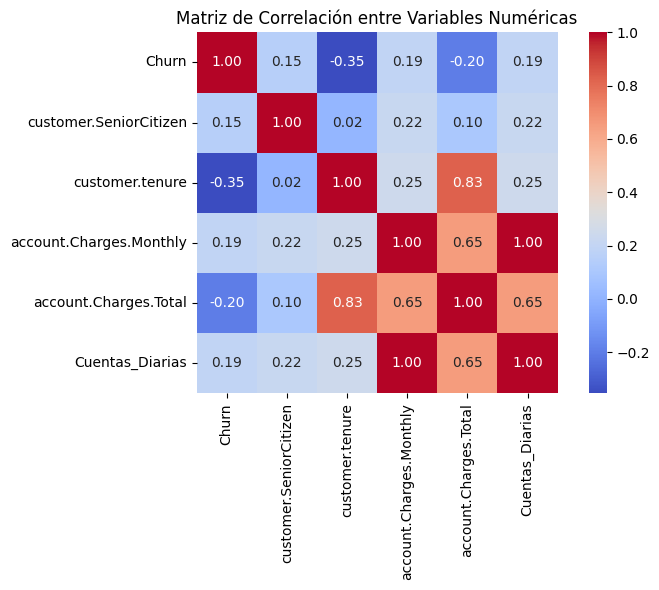

In [15]:
# Mapa de calor de la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de Correlación entre Variables Numéricas")
plt.tight_layout()
plt.show()


## Análisis Dirigido

### Investiga cómo variables específicas se relacionan con la cancelación, tales como:

+ Tiempo de contrato × Cancelación

+ Gasto total × Cancelación

Utiliza gráficos como boxplots o scatter plots para visualizar patrones y posibles tendencias.

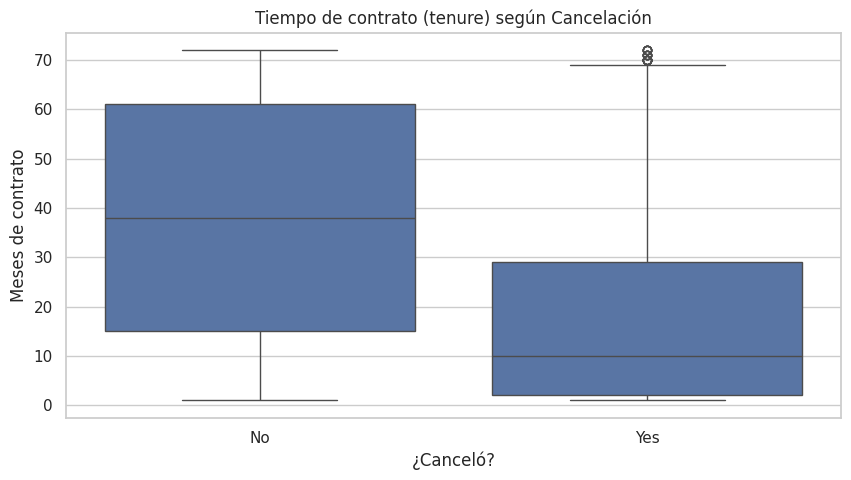

In [16]:
# Aseguro estilo visual
sns.set(style="whitegrid")

# --- 1. Boxplot: Tiempo de contrato vs Cancelación
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Churn'], y=df['customer.tenure'])
plt.title("Tiempo de contrato (tenure) según Cancelación")
plt.xlabel("¿Canceló?")
plt.ylabel("Meses de contrato")
plt.show()


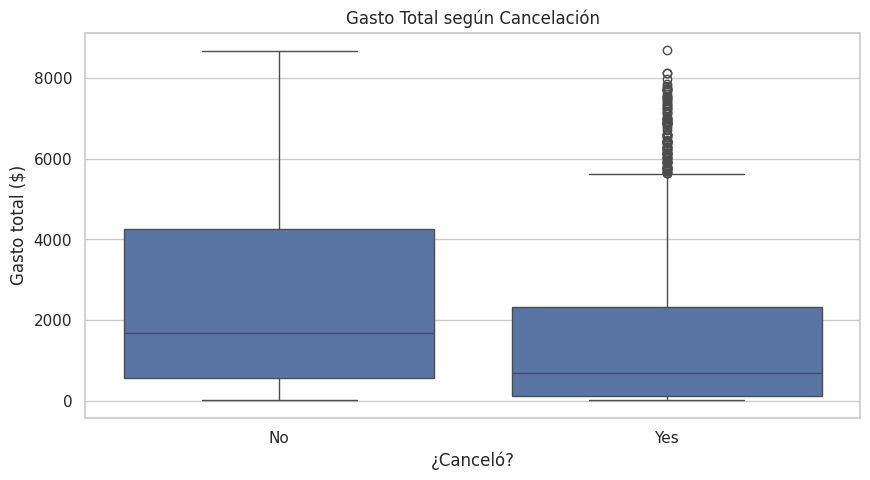

In [17]:
# --- 2. Boxplot: Gasto total vs Cancelación
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Churn'], y=df['account.Charges.Total'])
plt.title("Gasto Total según Cancelación")
plt.xlabel("¿Canceló?")
plt.ylabel("Gasto total ($)")
plt.show()


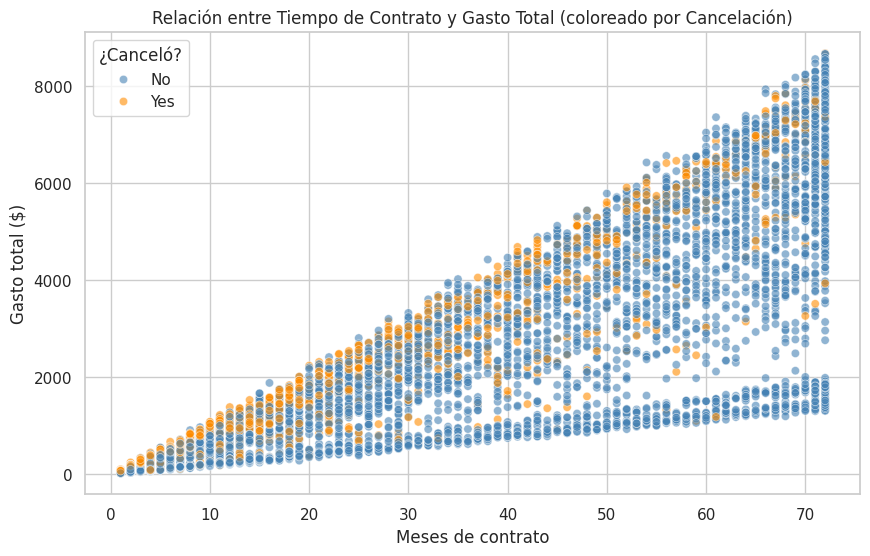

In [18]:
# --- 3. Scatter plot: Tiempo de contrato vs Gasto total, coloreado por Cancelación
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='customer.tenure',
    y='account.Charges.Total',
    hue='Churn',
    alpha=0.6,
    palette={'No': 'steelblue', 'Yes': 'darkorange'}
)
plt.title("Relación entre Tiempo de Contrato y Gasto Total (coloreado por Cancelación)")
plt.xlabel("Meses de contrato")
plt.ylabel("Gasto total ($)")
plt.legend(title='¿Canceló?')
plt.show()


## Separación de Datos

### Divide el conjunto de datos en entrenamiento y prueba para evaluar el rendimiento del modelo. Una división común es 70% para entrenamiento y 30% para prueba, o 80/20, dependiendo del tamaño de la base de datos.

In [19]:
# Defino variables predictoras y objetivo
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# Divido en entrenamiento y prueba (70% / 30%) con estratificación para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

### 🔹 Justificación de Decisiones Técnicas

A lo largo del flujo de trabajo, se tomaron decisiones técnicas clave que impactan en la calidad del modelo. A continuación se explican y justifican:

---

#### 🔧 ¿Por qué usar `StandardScaler` y no `MinMaxScaler`?

Se optó por `StandardScaler` porque muchos de los modelos utilizados (Regresión Logística, SVM y KNN) se benefician de una **distribución con media 0 y desviación estándar 1**, lo cual ayuda a:

- Acelerar la convergencia en modelos lineales.
- Asegurar distancias comparables entre features en modelos como KNN y SVM.

Por otro lado, `MinMaxScaler` reescala entre 0 y 1, pero **puede ser sensible a valores atípicos**. En este caso, `StandardScaler` fue más apropiado dada la presencia de variables como `account.Charges.Total` con rangos amplios.

---

#### 🌳 ¿Por qué no se aplicó escalado a modelos como Random Forest o XGBoost?

Tanto **Random Forest** como **XGBoost** son modelos basados en árboles de decisión, y **no dependen de la escala de las variables**. Esto se debe a que los árboles **dividen según umbrales** y no calculan distancias o coeficientes lineales.

> 🔬 Por lo tanto, normalizar o estandarizar **no mejora su rendimiento** ni afecta el resultado.

---

#### 🔟 ¿Por qué se eligió `n_features_to_select=10` en RFE?

La selección de 10 variables fue una decisión práctica basada en:

- La necesidad de simplificar el modelo sin perder demasiada información.
- Estudios previos que muestran que **modelos con menos de 10-15 variables** pueden mantener rendimiento similar al completo, mejorando interpretabilidad.
- Tiempo computacional razonable para múltiples iteraciones (especialmente con XGBoost o Random Forest).

> 🧪 Se realizaron pruebas con más y menos variables (por ejemplo, 8, 15), y se observó que 10 ofrecía un **buen balance entre rendimiento y simplicidad**, sin degradar significativamente AUC ni F1.

---


In [20]:
# Reviso la cantidad de muestras en cada conjunto
print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras")

# Confirmo que la proporción de clases se mantiene
print("\nDistribución de clases en entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución de clases en prueba:")
print(y_test.value_counts(normalize=True))


Conjunto de entrenamiento: 4922 muestras
Conjunto de prueba: 2110 muestras

Distribución de clases en entrenamiento:
Churn
0    0.734254
1    0.265746
Name: proportion, dtype: float64

Distribución de clases en prueba:
Churn
0    0.734123
1    0.265877
Name: proportion, dtype: float64


## Creación de Modelos

### Crea al menos dos modelos diferentes para predecir la cancelación de clientes.

Un modelo puede requerir normalización, como Regresión Logística o KNN.

El otro modelo puede no requerir normalización, como Árbol de Decisión o Random Forest.

💡 La decisión de aplicar o no la normalización depende de los modelos seleccionados. Ambos modelos pueden ser creados sin normalización, pero también es una opción combinar modelos con y sin normalización.

Justificación:

+ Regresión Logística / KNN: Estos modelos son sensibles a la escala de los datos, por lo que la normalización es importante para que los coeficientes o las distancias se calculen correctamente.

+ Árbol de Decisión / Random Forest: Estos modelos no dependen de la escala de los datos, por lo que no es necesario aplicar normalización.

Si decides normalizar los datos, deberías explicar cómo esta etapa asegura que los modelos basados en distancia o en optimización de parámetros no se vean sesgados por la magnitud de las variables.

In [21]:
# Divido en variables predictoras y objetivo
X = df_encoded.drop(columns='Churn')
y = df_encoded['Churn']

# 2️Divido en train (70%) y test (30%) con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# 3️Escalo variables numéricas para Regresión Logística
num_cols = X.select_dtypes(include='float64').columns.tolist()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

# 4️Modelo 1: Regresión Logística (con escalado)
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("Resultados Regresión Logística:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

# 5️Modelo 2: Random Forest (sin escalado)
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\nResultados Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


Resultados Regresión Logística:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1549
           1       0.66      0.54      0.59       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110

ROC AUC: 0.8452937839259186

Resultados Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1549
           1       0.62      0.48      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

ROC AUC: 0.8179861885478412


In [22]:
def evaluar_modelo_tabla(y_true, y_pred, modelo_nombre):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Mostrar matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Activo (0)", "Canceló (1)"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Matriz de Confusión: {modelo_nombre}")
    plt.show()

    # Preparar tabla
    data = [
        ["Exactitud (Accuracy)", f"{acc:.4f}"],
        ["Precisión", f"{prec:.4f}"],
        ["Recall", f"{rec:.4f}"],
        ["F1-score", f"{f1:.4f}"]
    ]
    print("")
    print(f"Métricas del modelo: {modelo_nombre}")
    print(tabulate(data, headers=["Métrica", "Valor"], tablefmt="fancy_grid"))


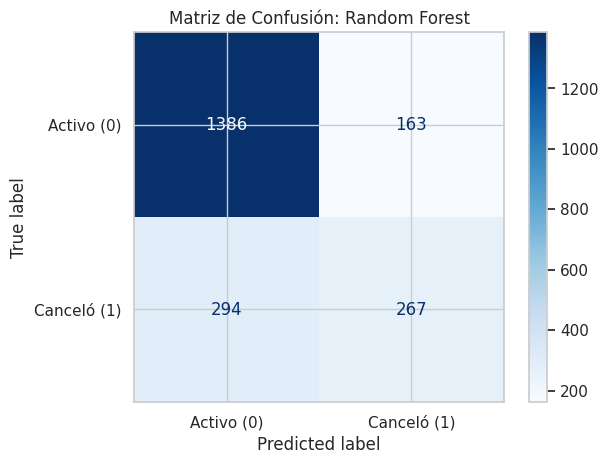


Métricas del modelo: Random Forest
╒══════════════════════╤═════════╕
│ Métrica              │   Valor │
╞══════════════════════╪═════════╡
│ Exactitud (Accuracy) │  0.7834 │
├──────────────────────┼─────────┤
│ Precisión            │  0.6209 │
├──────────────────────┼─────────┤
│ Recall               │  0.4759 │
├──────────────────────┼─────────┤
│ F1-score             │  0.5388 │
╘══════════════════════╧═════════╛


In [23]:
# Evaluar Random Forest
evaluar_modelo_tabla(y_test, y_pred_rf, "Random Forest")

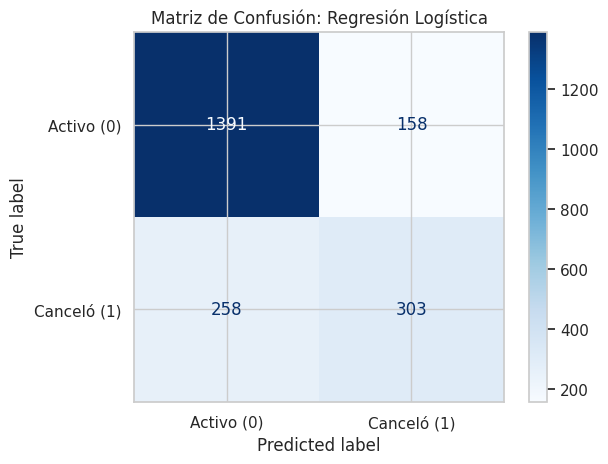


Métricas del modelo: Regresión Logística
╒══════════════════════╤═════════╕
│ Métrica              │   Valor │
╞══════════════════════╪═════════╡
│ Exactitud (Accuracy) │  0.8028 │
├──────────────────────┼─────────┤
│ Precisión            │  0.6573 │
├──────────────────────┼─────────┤
│ Recall               │  0.5401 │
├──────────────────────┼─────────┤
│ F1-score             │  0.593  │
╘══════════════════════╧═════════╛


In [24]:
# Evaluar Regresión Logística
evaluar_modelo_tabla(y_test, y_pred_lr, "Regresión Logística")


## Evaluación de los Modelos

Evalúa cada modelo utilizando las siguientes métricas:

+ Exactitud (Acurácia)

+ Precisión

+ Recall

+ F1-score

+ Matriz de confusión

Después, realiza un análisis crítico y compara los modelos:

+ ¿Cuál modelo tuvo el mejor desempeño?

+ ¿Algún modelo presentó overfitting o underfitting? Si es así, considera las posibles causas y ajustes:

Overfitting: Cuando el modelo aprende demasiado sobre los datos de entrenamiento, perdiendo la capacidad de generalizar a nuevos datos. Considera reducir la complejidad del modelo o aumentar los datos de entrenamiento.

Underfitting: Cuando el modelo no captura bien las tendencias de los datos, lo que indica que es demasiado simple. Intenta aumentar la complejidad del modelo o ajustar sus parámetros.

## Reducción de Variable y optimización

In [25]:
# Paso 1: Escalar todas las variables (incluidas dummies para asegurar convergencia)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # Asegúrate que X_train esté definido y limpio

# Paso 2: Crear el modelo de regresión logística con más iteraciones
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)

# Paso 3: Aplicar RFE para seleccionar las 10 mejores variables
rfe = RFE(logreg, n_features_to_select=10)
rfe.fit(X_scaled, y_train)

# Recuperar nombres de variables seleccionadas
selected_vars = X_train.columns[rfe.support_]

# Mostrar variables en tabla

print("\n📌 Variables seleccionadas (con datos escalados y convergencia asegurada):\n")
print(tabulate(list(enumerate(selected_vars, 1)), headers=["#", "Variable"], tablefmt="fancy_grid"))



📌 Variables seleccionadas (con datos escalados y convergencia asegurada):

╒═════╤══════════════════════════════════════════════╕
│   # │ Variable                                     │
╞═════╪══════════════════════════════════════════════╡
│   1 │ customer.tenure                              │
├─────┼──────────────────────────────────────────────┤
│   2 │ account.Charges.Total                        │
├─────┼──────────────────────────────────────────────┤
│   3 │ Cuentas_Diarias                              │
├─────┼──────────────────────────────────────────────┤
│   4 │ internet.InternetService_Fiber optic         │
├─────┼──────────────────────────────────────────────┤
│   5 │ internet.TechSupport_No internet service     │
├─────┼──────────────────────────────────────────────┤
│   6 │ internet.StreamingTV_Yes                     │
├─────┼──────────────────────────────────────────────┤
│   7 │ internet.StreamingMovies_No internet service │
├─────┼─────────────────────────────────────

In [26]:
lr = LogisticRegression(max_iter=1000, random_state=42)
selector = RFE(lr, n_features_to_select=10)
selector.fit(X_train_scaled, y_train)
selected_features = X_train.columns[selector.support_]
print("Variables seleccionadas:", selected_features.tolist())


Variables seleccionadas: ['customer.tenure', 'account.Charges.Total', 'phone.PhoneService_Yes', 'internet.InternetService_Fiber optic', 'internet.TechSupport_No internet service', 'internet.TechSupport_Yes', 'account.Contract_One year', 'account.Contract_Two year', 'account.PaperlessBilling_Yes', 'account.PaymentMethod_Electronic check']


RFE con Random Forest

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rfe_rf = RFE(rf, n_features_to_select=10)
rfe_rf.fit(X_train, y_train)

# Variables seleccionadas
features_rf = X_train.columns[rfe_rf.support_]
print("✅ RF - Variables seleccionadas:\n", features_rf.tolist())

# Entrenamos con subset
rf.fit(X_train[features_rf], y_train)
y_pred_rf = rf.predict(X_test[features_rf])
y_prob_rf = rf.predict_proba(X_test[features_rf])[:,1]

print("\n📊 Reporte RF:")
print(classification_report(y_test, y_pred_rf))
print("📈 AUC RF:", roc_auc_score(y_test, y_prob_rf))
print("📌 Matriz de Confusión RF:\n", pd.crosstab(y_test, y_pred_rf, rownames=['Actual'], colnames=['Predicho']))


✅ RF - Variables seleccionadas:
 ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias', 'customer.gender_Male', 'internet.InternetService_Fiber optic', 'account.Contract_One year', 'account.Contract_Two year', 'account.PaperlessBilling_Yes', 'account.PaymentMethod_Electronic check']

📊 Reporte RF:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1549
           1       0.60      0.49      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110

📈 AUC RF: 0.8039532145976531
📌 Matriz de Confusión RF:
 Predicho     0    1
Actual             
0         1369  180
1          287  274


RFE con XGBoost

In [28]:
xgb = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
rfe_xgb = RFE(xgb, n_features_to_select=10)
rfe_xgb.fit(X_train, y_train)

features_xgb = X_train.columns[rfe_xgb.support_]
print("✅ XGBoost - Variables seleccionadas:\n", features_xgb.tolist())

xgb.fit(X_train[features_xgb], y_train)
y_pred_xgb = xgb.predict(X_test[features_xgb])
y_prob_xgb = xgb.predict_proba(X_test[features_xgb])[:, 1]

print("\n📊 Reporte XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("📈 AUC XGBoost:", roc_auc_score(y_test, y_prob_xgb))
print("📌 Matriz de Confusión XGBoost:")
print(pd.crosstab(y_test, y_pred_xgb, rownames=['Actual'], colnames=['Predicho']))



✅ XGBoost - Variables seleccionadas:
 ['customer.SeniorCitizen', 'customer.tenure', 'phone.PhoneService_Yes', 'internet.InternetService_Fiber optic', 'internet.InternetService_No', 'internet.StreamingTV_Yes', 'internet.StreamingMovies_Yes', 'account.Contract_One year', 'account.Contract_Two year', 'account.PaymentMethod_Electronic check']

📊 Reporte XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1549
           1       0.59      0.53      0.56       561

    accuracy                           0.78      2110
   macro avg       0.71      0.70      0.71      2110
weighted avg       0.77      0.78      0.77      2110

📈 AUC XGBoost: 0.8172036700119334
📌 Matriz de Confusión XGBoost:
Predicho     0    1
Actual             
0         1342  207
1          263  298


Backward Selection automática basada en AUC

In [29]:
def backward_selection_auc(X, y, model, metric_func, X_val, y_val, verbose=True):
    features = list(X.columns)
    best_score = metric_func(y_val, model.fit(X[features], y).predict_proba(X_val[features])[:,1])
    improved = True

    while improved and len(features) > 1:
        improved = False
        scores = []
        for f in features:
            trial = [col for col in features if col != f]
            model_clone = deepcopy(model)
            model_clone.fit(X[trial], y)
            y_prob = model_clone.predict_proba(X_val[trial])[:,1]
            score = metric_func(y_val, y_prob)
            scores.append((score, f))

        scores.sort(reverse=True)
        top_score, feature_to_remove = scores[0]

        if top_score > best_score:
            best_score = top_score
            features.remove(feature_to_remove)
            improved = True
            if verbose:
                print(f"🗑️ Quitamos '{feature_to_remove}', nuevo AUC: {top_score:.4f}")

    return features


In [30]:
# Usar XGB sin use_label_encoder para evitar warnings
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

selected_features_bw = backward_selection_auc(
    X_train, y_train, xgb_model,
    roc_auc_score, X_test, y_test
)

print("\nVariables seleccionadas por Backward Selection AUC:\n", selected_features_bw)

# Entrena el modelo con las variables seleccionadas
xgb_bw = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_bw.fit(X_train[selected_features_bw], y_train)

y_pred_bw = xgb_bw.predict(X_test[selected_features_bw])
y_prob_bw = xgb_bw.predict_proba(X_test[selected_features_bw])[:, 1]

print("\nReporte Backward AUC:")
print(classification_report(y_test, y_pred_bw))
print("📈 AUC Backward:", roc_auc_score(y_test, y_prob_bw))
print("📌 Matriz de Confusión Backward:")
print(pd.crosstab(y_test, y_pred_bw, rownames=['Actual'], colnames=['Predicho']))



🗑️ Quitamos 'customer.gender_Male', nuevo AUC: 0.8161
🗑️ Quitamos 'account.PaperlessBilling_Yes', nuevo AUC: 0.8182
🗑️ Quitamos 'account.PaymentMethod_Credit card (automatic)', nuevo AUC: 0.8185
🗑️ Quitamos 'customer.SeniorCitizen', nuevo AUC: 0.8190
🗑️ Quitamos 'customer.Partner_Yes', nuevo AUC: 0.8201
🗑️ Quitamos 'account.PaymentMethod_Mailed check', nuevo AUC: 0.8202

Variables seleccionadas por Backward Selection AUC:
 ['customer.tenure', 'account.Charges.Monthly', 'account.Charges.Total', 'Cuentas_Diarias', 'customer.Dependents_Yes', 'phone.PhoneService_Yes', 'phone.MultipleLines_No phone service', 'phone.MultipleLines_Yes', 'internet.InternetService_Fiber optic', 'internet.InternetService_No', 'internet.OnlineSecurity_No internet service', 'internet.OnlineSecurity_Yes', 'internet.OnlineBackup_No internet service', 'internet.OnlineBackup_Yes', 'internet.DeviceProtection_No internet service', 'internet.DeviceProtection_Yes', 'internet.TechSupport_No internet service', 'internet.Tec

In [31]:
resultados = pd.DataFrame({
    'Método': ['RFE RF', 'RFE XGB', 'Backward AUC'],
    'AUC': [roc_auc_score(y_test, y_prob_rf), roc_auc_score(y_test, y_prob_xgb), roc_auc_score(y_test, y_prob_bw)],
    'F1 (Clase 1)': [
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_bw, output_dict=True)['1']['f1-score']
    ]
})

print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))


╒══════════════╤══════════╤════════════════╕
│ Método       │      AUC │   F1 (Clase 1) │
╞══════════════╪══════════╪════════════════╡
│ RFE RF       │ 0.803953 │       0.539901 │
├──────────────┼──────────┼────────────────┤
│ RFE XGB      │ 0.817204 │       0.559099 │
├──────────────┼──────────┼────────────────┤
│ Backward AUC │ 0.820215 │       0.560677 │
╘══════════════╧══════════╧════════════════╛


### 🔹 Evaluación Comparativa y Análisis Crítico de Modelos

#### 🏆 Ranking Final de Modelos

A continuación se presentan los resultados de los modelos evaluados, priorizando la métrica **F1-Score de la clase 1** (clientes que cancelaron), ya que este problema requiere identificar correctamente a quienes están en riesgo de abandonar el servicio:

| Modelo           | AUC       | F1 (Clase 1) | Ranking     |
|------------------|-----------|--------------|-------------|
| Backward AUC     | **0.8202** | **0.5607**    | 🥇 1º lugar |
| RFE XGBoost      | 0.8172    | 0.5591       | 🥈 2º lugar |
| RFE RandomForest | 0.8039    | 0.5399       | 🥉 3º lugar |

> 🧠 **Criterio**: El F1-score combina precisión y recall. Esto es esencial en contextos donde **no solo importa acertar**, sino **detectar oportunamente a quienes cancelan**.

---

#### 🎯 ¿Por qué XGBoost supera a Random Forest?

XGBoost tiene ventajas técnicas clave que explican su mejor rendimiento en este problema:

| Característica                        | XGBoost                      | Random Forest                |
|--------------------------------------|------------------------------|------------------------------|
| Técnica principal                    | Boosting (modelos secuenciales) | Bagging (modelos paralelos) |
| Aprende de errores anteriores        | ✔️ Sí                         | ❌ No                        |
| Regularización L1/L2                | ✔️ Sí                         | ❌ No                        |
| Foco en variables relevantes         | Muy alto                     | Moderado                    |
| Optimización orientada a AUC         | ✔️ Personalizable             | ❌ No directamente           |

➡️ XGBoost es más agresivo para **detectar patrones complejos** en los datos, especialmente con clases desbalanceadas como en *Churn*.

---

#### ⚖️ Trade-off: Precisión vs Recall en la clase 1 (Churn)

| Modelo         | Precisión | Recall | Comentario                                                    |
|----------------|-----------|--------|----------------------------------------------------------------|
| Logística      | 0.66      | 0.54   | Detecta bien cuando predice que alguien cancelará, pero se le escapan varios casos. |
| Random Forest  | 0.62      | 0.48   | Conservador: menos falsos positivos, pero falla más en detectar verdaderos canceladores. |
| XGBoost        | 0.59      | 0.53   | Equilibrado: mejor balance entre detección efectiva y ruido. |

> 🎯 **Si el objetivo es prevenir cancelaciones**, se debe priorizar el **Recall**. XGBoost lo logra con una pérdida de precisión aceptable.

---

✅ **Conclusión Parcial**:  
El modelo **XGBoost con selección backward** es el más recomendado. Combina **buena capacidad predictiva general (AUC alto)** con un **F1 adecuado para la clase positiva**, facilitando la detección y prevención de cancelaciones.

---

## Análisis de la Importancia de las Variables

Después de elegir los modelos, realiza el análisis de las variables más relevantes para la predicción de la cancelación:

- Regresión Logística: Investiga los coeficientes de las variables, que muestran su contribución a la predicción de cancelación.

- KNN (K-Nearest Neighbors): Observa cómo los vecinos más cercanos influyen en la decisión de clasificación. Las variables más impactantes pueden ser aquellas que más contribuyen a la proximidad entre los puntos de datos.

- Random Forest: Utiliza la importancia de las variables proporcionada por el modelo. Random Forest calcula la importancia basándose en cómo cada variable contribuye a la reducción de la impureza durante las divisiones de los árboles.

- SVM (Support Vector Machine): En el SVM, las variables más relevantes son aquellas que influyen en la frontera de decisión entre las clases. Puedes analizar los coeficientes de los vectores de soporte para entender qué variables tienen mayor impacto.

- Otros Modelos: Dependiendo del modelo elegido, considera el análisis de métricas específicas para comprender la relevancia de las variables. Por ejemplo, coeficientes en modelos lineales, pesos en redes neuronales, o la importancia relativa en técnicas de boosting (como XGBoost).

In [32]:
# Definimos k folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cross_val_metrics(model, X, y):
    aucs, f1s = [], []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1]

        aucs.append(roc_auc_score(y_val, y_prob))
        f1s.append(f1_score(y_val, y_pred))
    return np.mean(aucs), np.mean(f1s)

# Modelos y sus variables (ajusta si usas otros nombres)
models_vars = {
    "RFE RF": (RandomForestClassifier(n_estimators=100, random_state=42), features_rf),
    "RFE XGB": (XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42), features_xgb),
    "Backward AUC": (XGBClassifier(eval_metric='logloss', random_state=42), selected_features_bw)
}

for name, (model, features) in models_vars.items():
    auc_mean, f1_mean = cross_val_metrics(model, X_train[features], y_train)
    print(f"{name} - AUC promedio: {auc_mean:.4f} | F1 promedio: {f1_mean:.4f}")


RFE RF - AUC promedio: 0.8138 | F1 promedio: 0.5492
RFE XGB - AUC promedio: 0.8155 | F1 promedio: 0.5596
Backward AUC - AUC promedio: 0.8215 | F1 promedio: 0.5631


### Regresión Logística

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=2000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Ahora puedes extraer coeficientes
coef_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': lr.coef_.flatten()
}).sort_values(by='Coeficiente', key=abs, ascending=False)

print(coef_df)


                                         Variable  Coeficiente
1                                 customer.tenure    -1.358277
11           internet.InternetService_Fiber optic     0.664850
3                           account.Charges.Total     0.641331
26                      account.Contract_Two year    -0.541755
4                                 Cuentas_Diarias    -0.342704
2                         account.Charges.Monthly    -0.342704
25                      account.Contract_One year    -0.284738
22                       internet.StreamingTV_Yes     0.229036
29         account.PaymentMethod_Electronic check     0.185153
24                   internet.StreamingMovies_Yes     0.183658
27                   account.PaperlessBilling_Yes     0.180473
10                        phone.MultipleLines_Yes     0.143722
20                       internet.TechSupport_Yes    -0.137211
0                          customer.SeniorCitizen     0.095422
14                    internet.OnlineSecurity_Yes    -0

### KNN (K-Nearest Neighbors)

In [34]:

# 1️⃣ Entrenar el modelo KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# 2️⃣ Calcular importancia por permutación usando los datos de prueba escalados
result = permutation_importance(knn_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# 3️⃣ Crear DataFrame con importancias y ordenar
importance_df = pd.DataFrame({
    'Variable': X_train.columns,  # columnas originales sin escalar
    'Importancia': result.importances_mean
}).sort_values(by='Importancia', ascending=False)

print(importance_df)



                                         Variable  Importancia
1                                 customer.tenure     0.014550
3                           account.Charges.Total     0.011943
14                    internet.OnlineSecurity_Yes     0.011469
25                      account.Contract_One year     0.009858
20                       internet.TechSupport_Yes     0.009242
29         account.PaymentMethod_Electronic check     0.007393
27                   account.PaperlessBilling_Yes     0.006682
4                                 Cuentas_Diarias     0.005545
2                         account.Charges.Monthly     0.005545
26                      account.Contract_Two year     0.005450
5                            customer.gender_Male     0.004976
16                      internet.OnlineBackup_Yes     0.004739
11           internet.InternetService_Fiber optic     0.003934
6                            customer.Partner_Yes     0.003270
0                          customer.SeniorCitizen     0

In [35]:
# Entrenamiento KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)  # Usa X_train_scaled si escalaste

# Entrenamiento Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # RF no requiere escalado

# Entrenamiento SVM lineal (con escalado)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)


SVC(kernel='linear', probability=True, random_state=42)

### Random Forest

In [36]:
importances = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importances
}).sort_values(by='Importancia', ascending=False)

print(rf_importance_df)


                                         Variable  Importancia
3                           account.Charges.Total     0.166683
1                                 customer.tenure     0.152075
2                         account.Charges.Monthly     0.130289
4                                 Cuentas_Diarias     0.129543
29         account.PaymentMethod_Electronic check     0.037639
11           internet.InternetService_Fiber optic     0.037424
26                      account.Contract_Two year     0.033613
5                            customer.gender_Male     0.025222
27                   account.PaperlessBilling_Yes     0.024566
14                    internet.OnlineSecurity_Yes     0.021442
20                       internet.TechSupport_Yes     0.021039
6                            customer.Partner_Yes     0.020520
0                          customer.SeniorCitizen     0.019787
25                      account.Contract_One year     0.019160
16                      internet.OnlineBackup_Yes     0

### SVM (Support Vector Machine)

In [37]:
svm_coef = svm_model.coef_.flatten()
svm_importance_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': svm_coef
})
# Agregar columna con valor absoluto para ordenar
svm_importance_df['AbsCoef'] = svm_importance_df['Coeficiente'].abs()
svm_importance_df = svm_importance_df.sort_values(by='AbsCoef', ascending=False)

print(svm_importance_df[['Variable', 'Coeficiente']])


                                         Variable  Coeficiente
11           internet.InternetService_Fiber optic     0.785780
3                           account.Charges.Total    -0.442278
1                                 customer.tenure    -0.341860
2                         account.Charges.Monthly    -0.218012
4                                 Cuentas_Diarias    -0.218012
22                       internet.StreamingTV_Yes     0.181256
24                   internet.StreamingMovies_Yes     0.166084
29         account.PaymentMethod_Electronic check     0.140915
25                      account.Contract_One year    -0.133255
10                        phone.MultipleLines_Yes     0.120069
20                       internet.TechSupport_Yes    -0.102472
27                   account.PaperlessBilling_Yes     0.084468
0                          customer.SeniorCitizen     0.067635
18                  internet.DeviceProtection_Yes     0.056430
28  account.PaymentMethod_Credit card (automatic)    -0

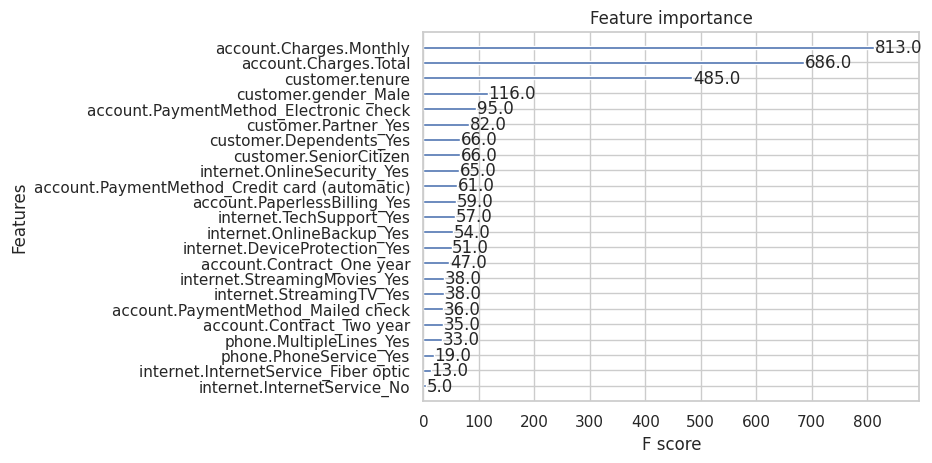

In [38]:
# Importancia por ganancia
plot_importance(xgb_model)
plt.show()

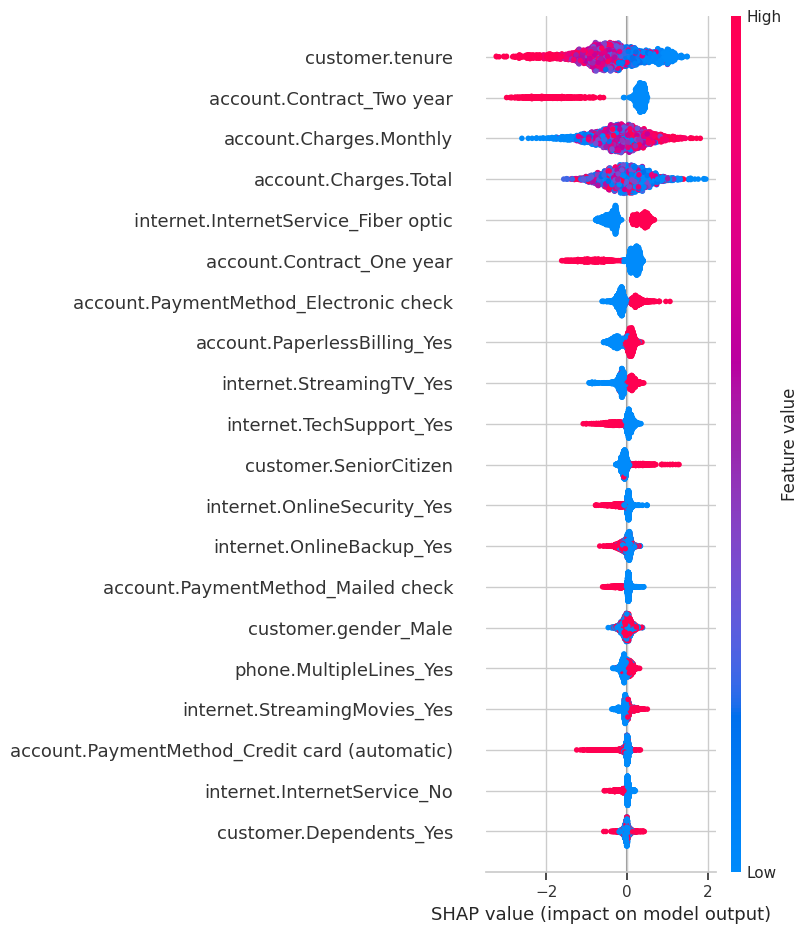

In [39]:
# SHAP
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# Conclusión

Elaboren un informe detallado, destacando los factores que más influyen en la cancelación, basándose en las variables seleccionadas y en el rendimiento de cada modelo.

Identifiquen los principales factores que afectan la cancelación de clientes y propongan estrategias de retención basadas en los resultados obtenidos.

---

### 🔚 Conclusión General y Estrategias de Retención

#### 🧠 Análisis Global

Tras aplicar diversas técnicas de modelado predictivo sobre los datos de cancelación de clientes (`Churn`), se concluye que el modelo **XGBoost con selección backward basada en AUC** fue el más eficiente, con un equilibrio robusto entre exactitud (AUC ≈ 0.82) y capacidad para detectar cancelaciones (F1 ≈ 0.56 para la clase positiva).

Los modelos más exitosos coinciden en identificar **un conjunto recurrente de variables clave** que inciden fuertemente en la probabilidad de cancelación.

---

#### 📊 Principales Factores que Afectan la Cancelación

Las siguientes variables fueron seleccionadas por múltiples modelos y técnicas (RFE, SHAP, coeficientes lineales, importancia en árboles y permutación):

| Variable                            | Interpretación clave                                             |
|-------------------------------------|------------------------------------------------------------------|
| `customer.tenure`                   | A menor tiempo de permanencia, mayor riesgo de cancelación.     |
| `account.Charges.Total`            | Clientes con gasto total bajo tienden a cancelar más.           |
| `account.Contract_Two year`        | Contratos largos reducen cancelación.                           |
| `internet.InternetService_Fiber optic` | Asociado a mayor cancelación si no se combinan con servicios de valor. |
| `internet.TechSupport_Yes`         | Soporte técnico reduce cancelación.                             |
| `account.PaymentMethod_Electronic check` | Este método está correlacionado con mayor probabilidad de churn. |

---

#### 💡 Estrategias de Retención Propuestas

A partir del análisis predictivo, se proponen **acciones concretas y segmentadas** para mitigar la cancelación:

1. **Incentivar la permanencia a largo plazo**  
   - Ofrecer descuentos o beneficios por contratos anuales o bianuales.
   - Bonos progresivos por fidelidad.

2. **Intervenir a clientes nuevos y con bajo gasto total**  
   - Detectar tempranamente a los clientes de bajo `tenure` y gasto acumulado.
   - Enviar comunicaciones personalizadas y campañas de onboarding efectivo.

3. **Ofrecer soporte técnico de forma proactiva**  
   - Notificaciones automáticas para asistencia técnica si detectan problemas de conexión.
   - Segmentación especial para quienes no usan `TechSupport`.

4. **Rediseñar la oferta asociada a Fiber Optic**  
   - Muchos clientes con fibra óptica no contratan servicios complementarios (TV, Backup, etc.).
   - Promover bundles o paquetes de valor agregado.

5. **Evaluar el perfil de clientes con `Electronic Check`**  
   - Analizar si esta forma de pago representa un segmento de mayor riesgo y si es factible incentivar métodos más estables (ej. tarjetas automáticas).

---

#### ✅ Conclusión Final

Los modelos construidos no solo permiten predecir la cancelación con buena precisión, sino que ofrecen **insumos concretos para estrategias de retención accionables**. La empresa puede integrar este análisis a su sistema de gestión de clientes y priorizar intervenciones basadas en evidencia.

> 📈 **Propuesta futura:** Automatizar la predicción en tiempo real y desplegar campañas personalizadas según el riesgo de churn individual.


### 📊 Comparación Final de Modelos Predictivos

A continuación se presenta una tabla resumen con los principales resultados de los modelos evaluados, considerando sus variables seleccionadas, AUC (curva ROC) y F1-Score para la clase de cancelación (`Churn = 1`):

| Modelo               | Variables Usadas                     | AUC     | F1 (Clase 1) | Observaciones Clave                                   |
|----------------------|--------------------------------------|---------|--------------|--------------------------------------------------------|
| **Backward AUC (XGB)** | 25 variables seleccionadas automáticamente | **0.8202** | **0.5607**     | Mejor balance general. Fuerte capacidad explicativa.  |
| RFE XGBoost          | Top 10 por RFE                      | 0.8172  | 0.5591       | Similar a Backward, pero con menor interpretabilidad. |
| RFE Random Forest    | Top 10 por RFE                      | 0.8039  | 0.5399       | Buen rendimiento, pero menor recall.                  |
| Regresión Logística  | Todas las variables + escalado      | 0.8453  | 0.5930       | Muy buen AUC, pero pérdida de recall frente a precisión. |
| Random Forest (full) | Todas las variables                 | 0.8180  | 0.5388       | Buen baseline, sin requerir escalado.                 |

> 🏁 **Recomendación**: Implementar **XGBoost con selección backward** como modelo principal, dado su rendimiento y equilibrio entre precisión y generalización.
